In [2]:
%pip install yfiles_jupyter_graphs --quiet 


Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
from graphrag.query.indexer_adapters import read_indexer_relationships
from yfiles_jupyter_graphs import GraphWidget
import matplotlib.pyplot as plt
import numpy as np
from openai import OpenAI
import matplotlib.pyplot as plt
from math import pi

In [6]:
import os
import pandas as pd

prompts = ['prompt_1', 'prompt_2', 'prompt_3']
categories = ['GPT-CE', 'GPT-OP', 'BERT', 'BM25', 'NAIVE']
base_path = 'output/evaluations'  
def count_violations_and_incompleteness(csv_filename):
    try:
        df = pd.read_csv(csv_filename)
        incompleteness_count = df['incompleteness'].sum() 
        violation_count = df['violation'].sum() 
        return incompleteness_count, violation_count
    except FileNotFoundError:
        print(f"File not found: {csv_filename}")
        return 0, 0  
    except KeyError:
        print(f"Missing required columns in {csv_filename}")
        return 0, 0 

results = {prompt: [] for prompt in prompts}

for prompt in prompts:
    prompt_folder_path = os.path.join(base_path, prompt)
    prompt_counts = []
    
    for category in categories:
        csv_filename = os.path.join(prompt_folder_path, f"{category}.csv")
        incompleteness_count, violation_count = count_violations_and_incompleteness(csv_filename)
        prompt_counts.append((incompleteness_count, violation_count))
    
    results[prompt] = prompt_counts
incompleteness_lists = []
violation_lists = []
for prompt in prompts:
    incompleteness_lists.append([count[0] for count in results[prompt]])  
    violation_lists.append([count[1] for count in results[prompt]]) 
    print(f"Prompt: {prompt}")
    print(f"Incompleteness: {[count[0] for count in results[prompt]]}")
    print(f"Violation: {[count[1] for count in results[prompt]]}")
    print()


Prompt: prompt_1
Incompleteness: [144, 112, 103, 95, 135]
Violation: [10, 25, 24, 14, 43]

Prompt: prompt_2
Incompleteness: [97, 41, 48, 51, 99]
Violation: [7, 10, 9, 7, 16]

Prompt: prompt_3
Incompleteness: [177, 169, 152, 153, 116]
Violation: [24, 25, 12, 18, 20]



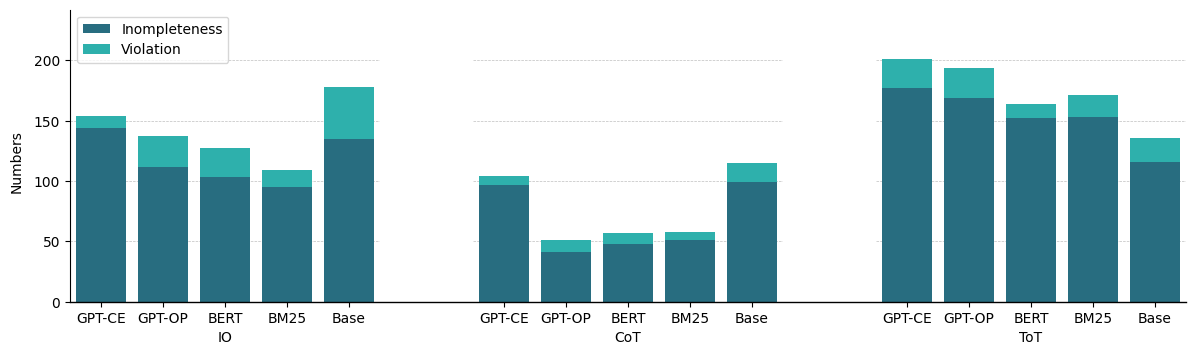

In [7]:


categories = ['GPT-CE', 'GPT-OP', 'BERT', 'BM25', 'Base']


colors = ['#286D80','#2EB0AC']
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
bar_width = 0.8
max_height = 220


for i in range(3):
    axes[i].bar(categories, incompleteness_lists[i], width=bar_width, label='Inompleteness', color=colors[0])
    axes[i].bar(categories, violation_lists[i], width=bar_width, bottom=incompleteness_lists[i], label='Violation', color=colors[1])
    if i == 0:
        axes[i].set_xlabel(f'IO')
    elif i == 1:
        axes[i].set_xlabel(f'CoT')
    else:
        axes[i].set_xlabel(f'ToT')
    axes[i].set_xlim(-0.5, len(categories)-0.5)  
    
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    if i != 0:
        axes[i].spines['left'].set_visible(False)
    
    
    if i != 0:
        axes[i].tick_params(left=False, labelleft=False)
    
    axes[i].yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
    axes[i].set_axisbelow(True)  
    axes[i].set_ylim(0, max_height * 1.1)  

fig.text(0, 0.5, 'Numbers', va='center', rotation='vertical')

axes[0].legend(loc='upper left')

plt.subplots_adjust(left=0.05, right=0.98, wspace=0.3, bottom=0.15)

fig.add_artist(plt.Line2D([0.05, 0.98], [0.15, 0.15], color='black', linewidth=1, transform=fig.transFigure))

plt.show()

In [4]:
# moved files from output/****-****
MODEL = "GPT-4o-CE"
report_df = pd.read_parquet(f"output/graphs/{MODEL}/artifacts/create_final_community_reports.parquet")
entity_df = pd.read_parquet(f"output/graphs/{MODEL}/artifacts/create_final_nodes.parquet")
entity_embedding_df = pd.read_parquet(f"output/graphs/{MODEL}/artifacts/create_final_entities.parquet")
relationship_df = pd.read_parquet(f"output/graphs/{MODEL}/artifacts/create_final_relationships.parquet")
relationships = read_indexer_relationships(relationship_df)

def convert_entities_to_dicts(df):
    """Convert the entities dataframe to a list of dicts for yfiles-jupyter-graphs."""
    nodes_dict = {}
    for _, row in df.iterrows():
        node_id = row["title"]
        if node_id not in nodes_dict:
            nodes_dict[node_id] = {
                "id": node_id,
                "properties": row.to_dict(),
            }
    return list(nodes_dict.values())


def convert_relationships_to_dicts(df):
    """Convert the relationships dataframe to a list of dicts for yfiles-jupyter-graphs."""
    relationships = []
    for _, row in df.iterrows():
        relationships.append({
            "start": row["source"],
            "end": row["target"],
            "properties": row.to_dict(),
        })
    return relationships


w = GraphWidget()
w.directed = True
w.nodes = convert_entities_to_dicts(entity_df)
w.edges = convert_relationships_to_dicts(relationship_df)
w.node_label_mapping = "title"
w.col = "white" 

def community_to_color(community):
    """Map a community to a color."""
    colors = [
        "crimson",
        "darkorange",
        "indigo",
        "cornflowerblue",
        "cyan",
        "teal",
        "green",
    ]
    return (
        colors[int(community) % len(colors)] if community is not None else "lightgray"
    )


def edge_to_source_community(edge):
    """Get the community of the source node of an edge."""
    source_node = next(
        (entry for entry in w.nodes if entry["properties"]["title"] == edge["start"]),
        None,
    )
    source_node_community = source_node["properties"]["community"]
    return source_node_community if source_node_community is not None else None

def edge_to_thickness(edge):
    weight = edge["properties"].get("weight", 1)  
    return 0.5 + weight  



w.node_color_mapping = lambda node: community_to_color(node["properties"]["community"])
w.edge_color_mapping = lambda edge: community_to_color(edge_to_source_community(edge))
w.node_scale_factor_mapping = lambda node: 2 + node["properties"]["size"] * 2 / 20
w.edge_thickness_factor_mapping = edge_to_thickness
w.circular_layout()
display(w)

GraphWidget(layout=Layout(height='800px', width='100%'))

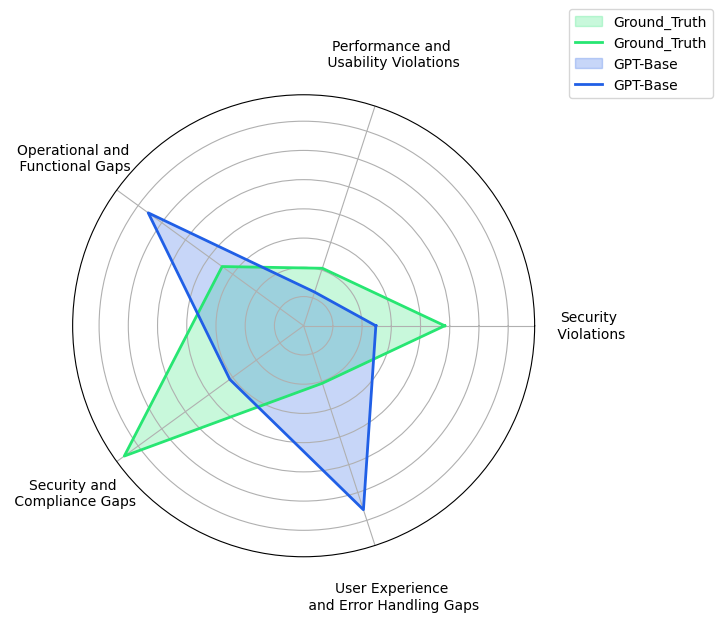

In [60]:


def plot_radar_chart(data_dict, title):
    num_vars = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    colors = {'Ground_Truth': '#27E672', 'GPT-Base': '#205FE6'}

    for model_name, data in data_dict.items():
        data = np.concatenate((data, [data[0]])) 
        ax.fill(angles, data, color=colors[model_name], alpha=0.25, label=model_name)
        ax.plot(angles, data, color=colors[model_name], linewidth=2, label=model_name)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])

    ax.set_xticklabels(categories, fontsize=10)
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('center')
        label.set_verticalalignment('center')
        label.set_position((label.get_position()[0], -0.15))  

    plt.title(title, size=15, color='blue', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.2))
    plt.show()

categories = [
    "Security\n Violations", 
    "Performance and\n Usability Violations", 
    "Operational and\n Functional Gaps", 
    "Security and\n Compliance Gaps", 
    "User Experience\n and Error Handling Gaps"
]
N = len(categories)
ground_truth_issues = [7, 3, 5, 11, 3]
ground_truth_issues_N = [x / sum(ground_truth_issues) for x in ground_truth_issues]

NAIVE_issues_classified = [53, 26, 141, 67, 142]
NAIVE_issues_classified_N = [x / sum(NAIVE_issues_classified) for x in NAIVE_issues_classified]

model_data = {
    'Ground_Truth': ground_truth_issues_N,
    'GPT-Base': NAIVE_issues_classified_N
}


plot_radar_chart(model_data, "")


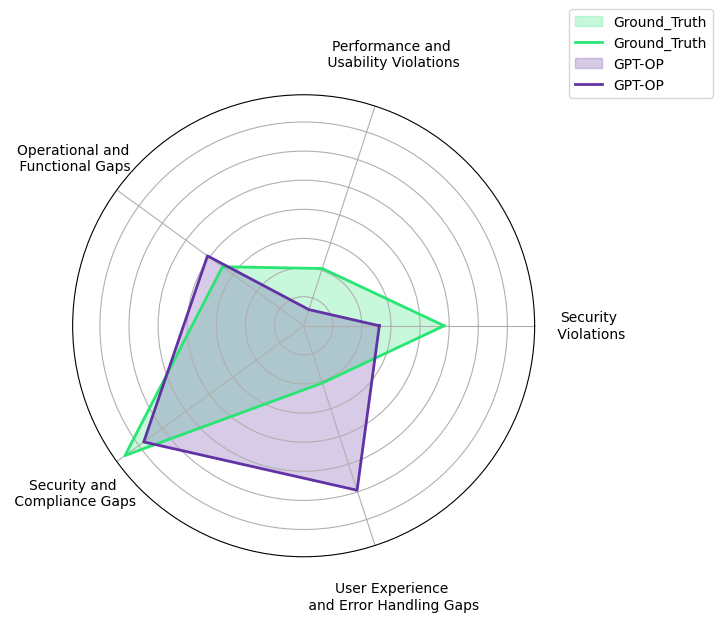

In [55]:

def plot_radar_chart(data_dict, title):
    num_vars = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    colors = {'Ground_Truth': '#27E672', 'GPT-OP': '#6132A4'}

    for model_name, data in data_dict.items():
        data = np.concatenate((data, [data[0]])) 
        ax.fill(angles, data, color=colors[model_name], alpha=0.25, label=model_name)
        ax.plot(angles, data, color=colors[model_name], linewidth=2, label=model_name)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])

    ax.set_xticklabels(categories, fontsize=10)
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('center')
        label.set_verticalalignment('center')
        label.set_position((label.get_position()[0], -0.15))  

    plt.title(title, size=15, color='blue', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.2))
    plt.show()
    
OP_issues_classified = [49, 11, 77, 128, 112]
OP_issues_classified_N = [x / sum(OP_issues_classified) for x in OP_issues_classified]

model_data = {
    'Ground_Truth': ground_truth_issues_N,
    'GPT-OP': OP_issues_classified_N
}



plot_radar_chart(model_data, "")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table
from matplotlib.patches import FancyBboxPatch


file_path = 'documents/requirements/results.xlsx'
df = pd.read_excel(file_path)


issue_type_abbr = {
    "Incompleteness": "INC",
    "Violation": "VIO"
}

category_abbr = {
    "Operational and Functional Gaps": "OFG",
    "Performance and Usability Violations": "PUV",
    "Security Violations": "SV",
    "Security and Compliance Gaps": "SCG",
    "User Experience and Error Handling Gaps": "UEG" 
}

df['Issue type'] = df['Issue type'].map(issue_type_abbr)
df['Category'] = df['Category'].map(category_abbr)

def get_cell_color(value):
    if value == 1:
        return "lightgreen"
    elif value == 0:
        return "lightcoral"
    else:
        return "white"

def plot_table(df):
    fig, ax = plt.subplots(figsize=(14, 10))  
    ax.set_axis_off()  

    table = Table(ax, bbox=[0, 0, 1, 1])

    wide_column_width = 0.16  
    narrow_column_width = 0.11  
    height = 1.0 / (df.shape[0] + 1)  

    for i, column in enumerate(df.columns):
        if i < 3:  
            cell = table.add_cell(0, i, wide_column_width, height, text=column, loc='center', facecolor='lightgrey', edgecolor='white')
        else: 
            cell = table.add_cell(0, i, narrow_column_width, height, text=column, loc='center', facecolor='lightgrey', edgecolor='white')
        cell.get_text().set_fontsize(8)  


    for row in range(df.shape[0]):
        for col in range(df.shape[1]):
            if (row == 0 or row == 26 or row == 25 or row == 27 or row == 17) and col < 3: 
                cell = table.add_cell(row + 1, col, wide_column_width, height,
                                      text=df.iloc[row, col],
                                      loc='center',
                                      facecolor='white',
                                      edgecolor='white')
                cell.get_text().set_color('darkred')  
            elif col >= 3:  
                value = df.iloc[row, col]
                facecolor = get_cell_color(value)
                table.add_cell(row + 1, col, narrow_column_width, height,
                              text='', loc='center',
                              facecolor=facecolor,
                              edgecolor='white')
            else:  
                cell = table.add_cell(row + 1, col, wide_column_width, height,
                                      text=df.iloc[row, col],
                                      loc='center',
                                      facecolor='white',
                                      edgecolor='white')
               
                cell.get_text().set_color('black') 

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.2)

    ax.add_table(table)

    
    legend_text = (
        "Legend:\n"
        "Issue type: INC = Incompleteness, VIO = Violation\n"
        "Category: OFG = Operational and Functional Gaps\n"
        "PUV = Performance and Usability Violations\n"
        "SV = Security Violations\n"
        "SCG = Security and Compliance Gaps\n"
        "UEG = User Experience and Error Handling Gaps"
    )

    plt.text(0, -0.25, legend_text, fontsize=10, va='top', ha='left',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgrey"))


    plt.title("", fontsize=16)
    plt.subplots_adjust(bottom=0.35) 
    plt.show()


plot_table(df)
